In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv(r'C:\Users\Marliya\Desktop\RegressionClassification\sales_data.csv')

print(df.head())
print(df.info())

   Product_ID   Sale_Date Sales_Rep Region  Sales_Amount  Quantity_Sold  \
0        1052  2023-02-03       Bob  North       5053.97             18   
1        1093  2023-04-21       Bob   West       4384.02             17   
2        1015  2023-09-21     David  South       4631.23             30   
3        1072  2023-08-24       Bob  South       2167.94             39   
4        1061  2023-03-24   Charlie   East       3750.20             13   

  Product_Category  Unit_Cost  Unit_Price Customer_Type  Discount  \
0        Furniture     152.75      267.22     Returning      0.09   
1        Furniture    3816.39     4209.44     Returning      0.11   
2             Food     261.56      371.40     Returning      0.20   
3         Clothing    4330.03     4467.75           New      0.02   
4      Electronics     637.37      692.71           New      0.08   

  Payment_Method Sales_Channel Region_and_Sales_Rep  
0           Cash        Online            North-Bob  
1           Cash        Re

In [3]:
df['Sales_Class'] = pd.cut(
    df['Sales_Amount'],
    bins=[0, 1000, 5000, df['Sales_Amount'].max()],
    labels=['Low', 'Medium', 'High']
)


In [4]:
target_column = 'Sales_Class'

X = df.drop(columns=[target_column])
y = df[target_column]


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

In [6]:
if y.dtype == "object":
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [9]:
y_pred = model.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       112
         Low       1.00      1.00      1.00        24
      Medium       1.00      1.00      1.00        64

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:

[[112   0   0]
 [  0  24   0]
 [  0   0  64]]


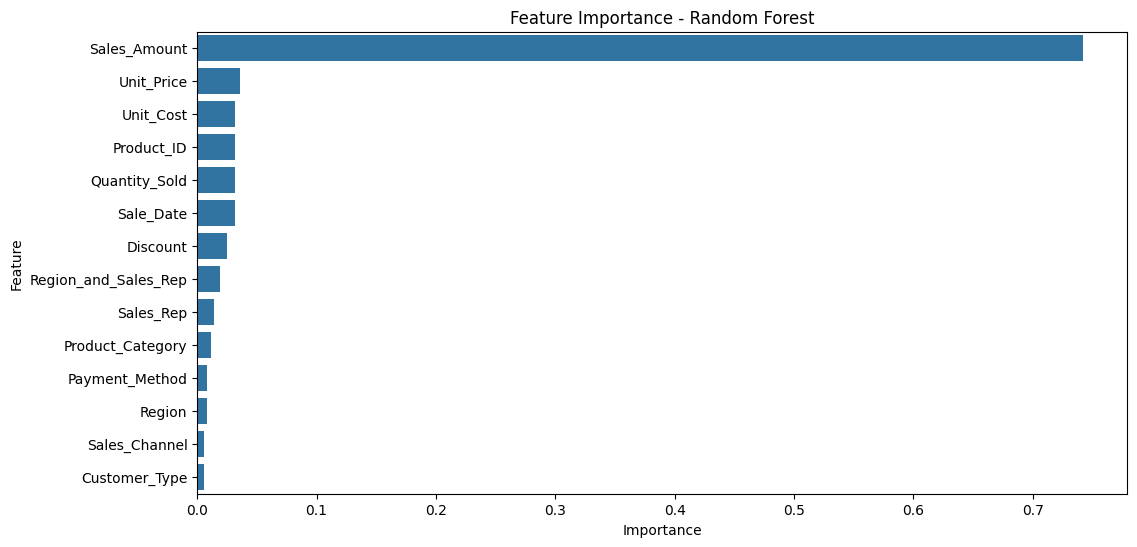

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
features = X.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [12]:
new_input = {
    'Product_ID': 'P1001',
    'Sale_Date': '2023-08-15',
    'Sales_Rep': 'John',
    'Region': 'East',
    'Quantity_Sold': 6,
    'Product_Category': 'Electronics',
    'Unit_Cost': 500,
    'Unit_Price': 700,
    'Customer_Type': 'Regular',
    'Discount': 10,
    'Payment_Method': 'Card',
    'Sales_Channel': 'Online',
    'Region_and_Sales_Rep': 'East_John'
}


In [13]:
new_df = pd.DataFrame([new_input])

# add missing columns
for col in X.columns:
    if col not in new_df.columns:
        new_df[col] = 0

# reorder columns
new_df = new_df[X.columns]

In [14]:
for col in new_df.columns:
    if col in label_encoders:
        le = label_encoders[col]
        new_df[col] = new_df[col].apply(
            lambda x: x if x in le.classes_ else le.classes_[0]
        )
        new_df[col] = le.transform(new_df[col])

In [15]:
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

le_product_id = LabelEncoder()
X['Product_ID'] = le_product_id.fit_transform(X['Product_ID'])

In [16]:
import numpy as np
import pandas as pd

# -------------------------------
# Safe Label Encoding Function
# -------------------------------
def safe_label_encode(le, series):
    """
    Encode known labels using LabelEncoder
    Unseen labels -> -1
    """
    return series.apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )

# -------------------------------
# Encode input features
# -------------------------------
new_df = new_df.copy()  # safety

# Encode Product_ID safely
new_df['Product_ID'] = safe_label_encode(
    le_product_id,
    new_df['Product_ID']
)

# -------------------------------
# Prediction
# -------------------------------
prediction = model.predict(new_df)

# -------------------------------
# Handle prediction output correctly
# -------------------------------
if isinstance(prediction[0], (int, np.integer)):
    # Numeric prediction → inverse transform
    predicted_class = le_target.inverse_transform(prediction)[0]
else:
    # Already string label
    predicted_class = prediction[0]

print("✅ Predicted Class:", predicted_class)


✅ Predicted Class: Low


In [17]:
import joblib

In [18]:
joblib.dump(model, "sales_rf_model.pkl")
print("✅ Random Forest model saved")

✅ Random Forest model saved


In [19]:
joblib.dump(label_encoders, "input_label_encoders.pkl")
print("✅ Input label encoders saved")

✅ Input label encoders saved


In [20]:
joblib.dump(le_target, "target_label_encoder.pkl")
print("✅ Target label encoder saved")

✅ Target label encoder saved


In [21]:
# Load model
loaded_model = joblib.load("sales_rf_model.pkl")

# Load encoders
label_encoders = joblib.load("input_label_encoders.pkl")
le_target = joblib.load("target_label_encoder.pkl")

print("✅ Model & encoders loaded")

✅ Model & encoders loaded


In [22]:
import joblib

joblib.dump(model, "random_forest_model.pkl")
joblib.dump(X.columns, "model_columns.pkl")

print("Model saved successfully")

Model saved successfully
